## This notebook runs the training pipeline and perform some preliminary test

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D,AveragePooling1D, Input, concatenate, BatchNormalization, Activation, Multiply, Permute, BatchNormalization, Attention
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras import callbacks
import tensorflow as tf
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d
import tensorflow as tf
import keras
from keras import backend as k
from keras.callbacks import Callback, LearningRateScheduler

2024-11-05 11:27:10.684617: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### utils to make emission & absorption line masks

Text(0.5, 0, 'wavelengt [AA]')

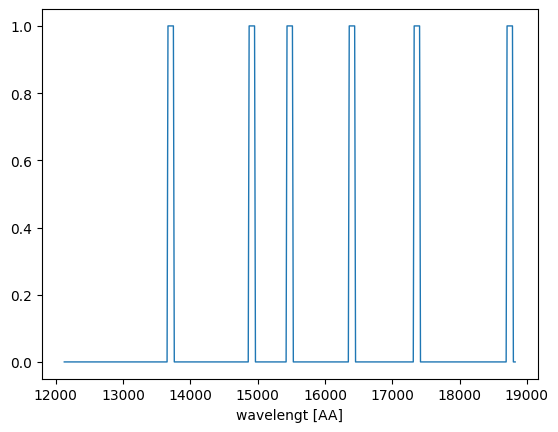

In [2]:
# a list of emission lines and their rest wavelengths in Angstrom, to overlay on the spectra
emission_lines_rest = {
    'Ly_alpha':1215.67,     # Lyman-alpha
    'NV':1240.81,           # Nitrogen-V
    'CIV':1549.48,           # Carbon IV
    'HeII_1':1640.0,         # Helium II
    'CIII':1908.72,          # Carbon III
    'CII':2326,              # Carbon II
    'NeIV':2424,             # Neon IV
    'MgII':2799.11,          # Magnesium II
    'NeV':3426.03,           # Neon V
    'OII':3727.0,            # Oxygen II
    'NeIII':3868.76,         # Neon III
    'Hdelta':4101.73,        # Hydrogen-delta
    'Hgamma':4340.46,        # Hydrogen-gamma
    'HeII_2':4685.64,        # Helium II
    'Hbeta':4861.33,         # Hydrogen-beta
    'OIII_1':4958.91,        # Oxygen III
    'OIII_2':5006.84,        # Oxygen III
    'HeI_1':5875.64,         # Helium I
    'OI_1':6300.3,           # Oxygen I
    'OI_2':6363.78,          # Oxygen I
    'NII_1':6548.05,         # Nitrogen II
    'Halpha':6562.81,        # Hydrogen-alpha
    'NII_2':6583.45,         # Nitrogen II
    'SII':6720,             # Sulfur II
    # 'Pa10':9016,             # Paschen 10
    'SIII_1':9068.62,        # Sulfur III
    # 'Pa9':9228.97,           # Paschen 9
    'SIII_2':9530.62,        # Sulfur III
    # 'Pa8':9545.93,           # Paschen 8
    # 'Padelta':10049.3,       # Paschen delta
    'HeII_3':10126.0,        # Helium II
    'HeI_2':10830.3,         # Helium I
    # 'Pagamma':10938.0,       # Paschen-gamma
    # 'Pabeta':12818.0,        # Paschen-beta
}


import pickle
# Load the wavelength axis
with open('wavelength_axis.pkl', 'rb') as f:
    wavelength_axis = pickle.load(f)


def create_emission_output(z, wavelength_axis, emission_lines_rest, threshold=15, adjacent_channels=3):
    """
    Create an emission line mask output array based on the redshift (z), wavelength axis, emission lines,
    and a threshold value (in Angstrom) to check if the line is present in the wavelength domain.
    The number of adjacent channels to mark on either side of the predicted position is determined by
    the adjacent_channels parameter.
    """
    emission_output = np.zeros_like(wavelength_axis)
    for line in emission_lines_rest:
        emitted_wavelength = emission_lines_rest[line]
        observed_wavelength = emitted_wavelength * (1 + z)
        idx, nearest_wavelength = find_nearest_index(wavelength_axis, observed_wavelength)

        # Check if the nearest wavelength is within the threshold
        if np.abs(nearest_wavelength - observed_wavelength) <= threshold:
            # Mark the predicted position and adjacent channels on either side
            start_idx = max(idx - adjacent_channels, 0)  # Ensure index is not less than 0
            end_idx = min(idx + adjacent_channels + 1, len(emission_output))  # Ensure index does not exceed array length
            emission_output[start_idx:end_idx] = 1 
    return emission_output

def find_nearest_index(array, value):
    """ Find nearest index in array for given value and return the index and the nearest value """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

# ------------ visualisation ------------
# check the emission line mask for a given redshift
z = 3 # Example redshift
emission_output_example = create_emission_output(z, wavelength_axis, emission_lines_rest)
plt.plot(wavelength_axis, emission_output_example, lw=1)
plt.xlabel('wavelengt [AA]')

### redshift discrete binning

In [3]:
import scipy.ndimage

# Step resolution for redshift bins
# ----------------- input  -----------------
step_resolution = 0.005 # agreed with Anna 

bin_categories = np.arange(0.15, 4.1, step=step_resolution).round(decimals=6) 
# found through reconstructed_df['z'] min and max values, with some 0.1 buffer.
# ------------------------------------------

# Create categorical labels for redshift bins
def create_categorical_labels(labels, sigma):
    categorical_labels = np.zeros((len(labels), len(bin_categories)))
    for i, label in enumerate(labels):
        bin_index = np.digitize(label, bin_categories) - 1  # -1 for zero-indexing
        categorical_labels[i, bin_index] = 1
        categorical_labels[i, :] = scipy.ndimage.gaussian_filter(categorical_labels[i, :], sigma=sigma)
    return categorical_labels

In [4]:
bin_categories.shape

(790,)

### load training set

In [5]:
# load the training dataset
df_train = pd.read_pickle('train_dataset.pickle')

# load the training normalized spectra
with open('spectra_train_normalized.pkl', 'rb') as file:
    spectra_train_normalized = pickle.load(file)

# assign a X_train variable to the normalized spectra, to be used in the model. 
# This helps to reuse different types of input data in the model in the future.
X_train = spectra_train_normalized

# Extract labels for training set
all_redshift_train = df_train['z'].values

# define labels: make Y
Y_train = all_redshift_train

# Create emission line masks for training set
emission_line_masks_train = np.array([create_emission_output(z, wavelength_axis, emission_lines_rest) for z in all_redshift_train])

# Convert labels to categorical
Y_train_categorical = create_categorical_labels(Y_train, sigma=0)

# Load and concatenate continuum data
with open('train_continuum.pkl', 'rb') as file:
    train_continuum = pickle.load(file)

Y_train_mstar = df_train['log_m'].values
Y_train_type = df_train['type'].values

# one-hot encode the type labels (note that now the labels are only 1,2 because I don't have SF yet)
Y_train_type_onehot = keras.utils.to_categorical(Y_train_type - 1) # -1 is to make the labels 0,1 (when will have SF, will be 0,1,2)

### load validation set

In [6]:
# load the validation dataset
df_val = pd.read_pickle('validation_dataset.pickle')

# load the validation normalized spectra
with open('spectra_val_normalized.pkl', 'rb') as file:
    spectra_val_normalized = pickle.load(file)

# assign a X_val variable to the normalized spectra, to be used in the model. 
# This helps to reuse different types of input data in the model in the future.
X_val = spectra_val_normalized

# Extract labels for validation set
all_redshift_val = df_val['z'].values

# define labels: make Y
Y_val = all_redshift_val

# Create emission line masks for validation set
emission_line_masks_val = np.array([create_emission_output(z, wavelength_axis, emission_lines_rest) for z in all_redshift_val])

# Convert labels to categorical
Y_val_categorical = create_categorical_labels(Y_val, sigma=0)

# Load and concatenate continuum data
with open('val_continuum.pkl', 'rb') as file:
    val_continuum = pickle.load(file)

Y_val_mstar = df_val['log_m'].values
Y_val_type = df_val['type'].values

# one-hot encode the type labels (note that now the labels are only 1,2 because I don't have SF yet)
Y_val_type_onehot = keras.utils.to_categorical(Y_val_type - 1) # -1 is to make the labels 0,1 (when will have SF, will be 0,1,2)

### load test set

In [7]:
# load the test dataset
df_test = pd.read_pickle('test_dataset.pickle')

# load the test normalized spectra
with open('spectra_test_normalized.pkl', 'rb') as file:
    spectra_test_normalized = pickle.load(file)

# assign a X_test variable to the normalized spectra, to be used in the model. 
# This helps to reuse different types of input data in the model in the future.
X_test = spectra_test_normalized

# Extract labels for test set
all_redshift_test = df_test['z'].values

# define labels: make Y
Y_test = all_redshift_test

# Create emission line masks for test set
emission_line_masks_test = np.array([create_emission_output(z, wavelength_axis, emission_lines_rest) for z in all_redshift_test])

# Convert labels to categorical
Y_test_categorical = create_categorical_labels(Y_test, sigma=0)

# Load and concatenate continuum data
with open('test_continuum.pkl', 'rb') as file:
    test_continuum = pickle.load(file)

Y_test_mstar = df_test['log_m'].values
Y_test_type = df_test['type'].values

# one-hot encode the type labels (note that now the labels are only 1,2 because I don't have SF yet)
Y_test_type_onehot = keras.utils.to_categorical(Y_test_type - 1) # -1 is to make the labels 0,1 (when will have SF, will be 0,1,2)

### normalise continuum points, mstar and other possible Y output

In [8]:
# Calculating the mean and standard deviation of the training continuum data
continuum_mean = train_continuum.mean()
continuum_std = train_continuum.std()

# Normalizing the continuum data
train_continuum = (train_continuum - continuum_mean) / continuum_std
val_continuum = (val_continuum - continuum_mean) / continuum_std
test_continuum = (test_continuum - continuum_mean) / continuum_std

# Calculating the mean and standard deviation of the training stellar mass data
mstar_mean, mstar_std = Y_train_mstar.mean(), Y_train_mstar.std()
Y_train_mstar = (Y_train_mstar - mstar_mean) / mstar_std

# Apply the same transformation to validation and test sets
Y_val_mstar = (Y_val_mstar - mstar_mean) / mstar_std
Y_test_mstar = (Y_test_mstar - mstar_mean) / mstar_std


# modelling NN

In [56]:
from tensorflow.keras.layers import Input, Conv1D, Add, Activation, AveragePooling1D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model

def create_multitask_model(input_shape, num_categories, continuum_shape):
    # Shared spectral layers
    spectral_input = Input(shape=input_shape)
    
    def residual_block(x, filters, kernel_size):
        shortcut = Conv1D(filters, kernel_size = 1, padding='same')(x)  
        x = Conv1D(filters, kernel_size, activation='relu', padding='same')(x)
        x = Conv1D(filters, kernel_size, activation='relu', padding='same')(x)
        x = Add()([shortcut, x])
        # x = Activation('elu')(x)
        return x

    x = residual_block(spectral_input, filters=16, kernel_size=11)
    x = AveragePooling1D(pool_size=2)(x)
    x = residual_block(x, filters=32, kernel_size=5)
    x = AveragePooling1D(pool_size=2)(x)
    x = residual_block(x, filters=64, kernel_size=5)
    x = AveragePooling1D(pool_size=2)(x)

    shared_spectral_features = Flatten()(x)

    # Emission line location prediction branch
    emission_branch = Dense(64, activation='relu')(shared_spectral_features)
    emission_branch = Dropout(0.2)(emission_branch)
    emission_branch = Dense(128, activation='relu')(emission_branch)
    emission_branch = Dropout(0.2)(emission_branch)
    emission_output = Dense(input_shape[0], activation='sigmoid', name='emission_output')(emission_branch)

    # Continuum input and processing
    continuum_input = Input(shape=continuum_shape)
    continuum_processed = Dense(32, activation='relu')(continuum_input)

    # Combine spectral features with processed continuum and emission branch output
    combined_features = Concatenate()([shared_spectral_features, continuum_processed, emission_branch])

    # Redshift prediction branch
    redshift_branch = Dense(64, activation='relu')(combined_features)
    redshift_branch = Dropout(0.2)(redshift_branch)
    redshift_branch = Dense(128, activation='relu')(redshift_branch)
    redshift_branch = Dropout(0.2)(redshift_branch)    
    redshift_output = Dense(num_categories, activation='softmax', name='redshift_output')(redshift_branch)

    # Stellar Mass (Mstar) prediction branch
    mstar_branch = Dense(64, activation='relu')(combined_features)
    mstar_branch = Dropout(0.2)(mstar_branch)
    mstar_branch = Dense(32, activation='relu')(mstar_branch)
    mstar_branch = Dropout(0.2)(mstar_branch)
    mstar_output = Dense(1, activation='linear', name='mstar_output')(mstar_branch)

    # Type prediction branch (binary classification)
    type_branch = Dense(32, activation='relu')(combined_features)
    type_branch = Dropout(0.2)(type_branch)
    type_branch = Dense(32, activation='relu')(type_branch)
    type_branch = Dropout(0.2)(type_branch)
    type_output = Dense(2, activation='softmax', name='type_output')(type_branch) 
    # not using sigmoid for the classification task, 
    # as softmax is more suitable for multi-class classification, 
    # and in the future I'll put in SF galaxies, i.e. a third class.

    # Define the model with four outputs
    model = Model(inputs=[spectral_input, continuum_input], outputs=[redshift_output, emission_output, mstar_output, type_output])

    return model

# Create the model
model = create_multitask_model(input_shape=(X_train.shape[1], 1), 
                               num_categories=len(bin_categories), 
                               continuum_shape=train_continuum.shape[1:])

model.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 501, 1)]     0           []                               
                                                                                                  
 conv1d_64 (Conv1D)             (None, 501, 16)      192         ['input_15[0][0]']               
                                                                                                  
 conv1d_63 (Conv1D)             (None, 501, 16)      32          ['input_15[0][0]']               
                                                                                                  
 conv1d_65 (Conv1D)             (None, 501, 16)      2832        ['conv1d_64[0][0]']              
                                                                                            

In [57]:
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

class MetricsPlotter(Callback):
    def __init__(self, task_names, regression_tasks=None):
        self.task_names = task_names
        self.regression_tasks = regression_tasks if regression_tasks is not None else []
        self.train_loss = []
        self.val_loss = []
        self.task_metrics = {task: {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []} for task in task_names}

    def on_epoch_end(self, epoch, logs=None):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

        for task in self.task_names:
            self.task_metrics[task]['train_loss'].append(logs.get(f'{task}_loss'))
            self.task_metrics[task]['val_loss'].append(logs.get(f'val_{task}_loss'))
            # Accuracy is relevant for classification tasks, but not for regression tasks
            if task not in self.regression_tasks:
                self.task_metrics[task]['train_acc'].append(logs.get(f'{task}_accuracy'))
                self.task_metrics[task]['val_acc'].append(logs.get(f'val_{task}_accuracy'))

        self.plot_metrics(epoch)

    def plot_metrics(self, epoch):
        clear_output(wait=True)  # Clear the output to update the plot in-place
        fig, axs = plt.subplots(2, 3, figsize=(18, 8))  # 2 rows, 3 columns

        # Total Loss
        axs[0, 0].plot(range(epoch+1), self.train_loss, label='Training Loss')
        axs[0, 0].plot(range(epoch+1), self.val_loss, label='Validation Loss')
        axs[0, 0].set_title('Total Loss')
        axs[0, 0].legend()

        # Task-specific Losses
        for i, task in enumerate(self.task_names):
            row, col = divmod(i+1, 3)  # Start plotting from axs[0, 1] onward
            axs[row, col].plot(range(epoch+1), self.task_metrics[task]['train_loss'], label=f'{task} Training Loss')
            axs[row, col].plot(range(epoch+1), self.task_metrics[task]['val_loss'], label=f'{task} Validation Loss')
            axs[row, col].set_title(f'{task.capitalize()} Loss')
            axs[row, col].legend()

        # Combined Accuracy Plot (only for classification tasks)
        for task in self.task_names:
            if task not in self.regression_tasks:  # Exclude regression tasks like `emission_output`
                axs[1, 2].plot(range(epoch+1), self.task_metrics[task]['train_acc'], label=f'{task} Training Accuracy', linestyle='solid')
                axs[1, 2].plot(range(epoch+1), self.task_metrics[task]['val_acc'], label=f'{task} Validation Accuracy', linestyle='dashed')
        axs[1, 2].set_title('Combined Accuracy')
        axs[1, 2].legend()

        plt.tight_layout()
        display(fig)  # Display the updated figure
        plt.close(fig)  # Close the figure to prevent duplication in output



### compile & run

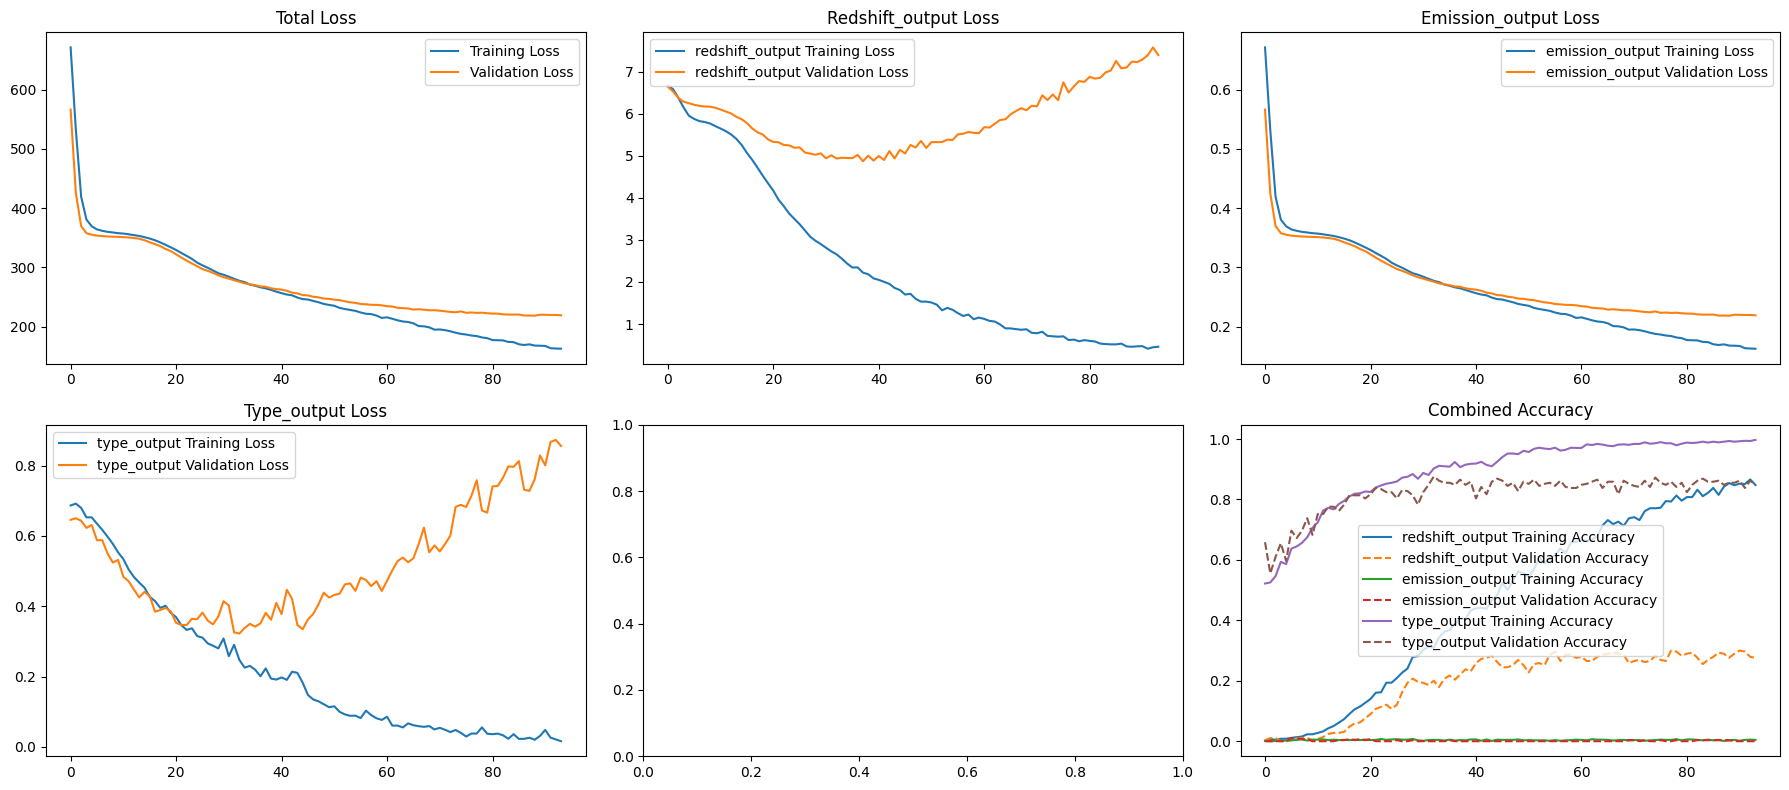

6/6 [==============================] - 2s 336ms/step - loss: 162.6763 - redshift_output_loss: 0.4602 - emission_output_loss: 0.1627 - mstar_output_loss: 5.2423 - type_output_loss: 0.0164 - redshift_output_accuracy: 0.8477 - emission_output_accuracy: 0.0044 - type_output_accuracy: 0.9970 - val_loss: 219.1203 - val_redshift_output_loss: 7.3963 - val_emission_output_loss: 0.2190 - val_mstar_output_loss: 2.5892 - val_type_output_loss: 0.8555 - val_redshift_output_accuracy: 0.2759 - val_emission_output_accuracy: 0.0000e+00 - val_type_output_accuracy: 0.8483 - lr: 5.0000e-04
Epoch 94: early stopping


In [58]:
from keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Learning rate schedule function
def lr_schedule(epoch, lr):
    initial_lr = 0.001
    final_lr = 0.0005
    switch = 50
    if epoch < switch:
        return initial_lr - (epoch * (initial_lr - final_lr) / switch)
    else:
        return final_lr

# Add LearningRateScheduler to callbacks
lr_scheduler = LearningRateScheduler(lr_schedule)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.005),
    loss={
        'redshift_output': 'categorical_crossentropy',   # Classification loss
        'emission_output': 'binary_crossentropy',        # Binary classification loss for emission lines
        'mstar_output': 'mse',                           # Mean Squared Error for Mstar regression
        'type_output': 'categorical_crossentropy'        # categorical classification loss for type
    },
    loss_weights={
        'redshift_output': 0.01,
        'emission_output': 1000,
        'mstar_output': 0, # I swithed off the mstar loss as it has some problems
        'type_output': 0.01
    },
    metrics={
        'redshift_output': 'accuracy',
        'emission_output': 'accuracy',
        'type_output': 'accuracy'
    }
)

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',             # Monitor the validation loss
    patience=5,                   # Number of epochs with no improvement after which training will be stopped
    verbose=1,                      # To log when training is stopped
    restore_best_weights=True       # Restores model weights from the epoch with the best value of the monitored quantity
)

# Instantiate the updated MetricsPlotter callback
metrics_plotter = MetricsPlotter(
    task_names=['redshift_output', 'emission_output', 'type_output'],
    regression_tasks=['mstar_output']  # Only Mstar is a regression task now
)

# Train the model with the callbacks
history = model.fit(
    [X_train, train_continuum],  # Training inputs
    {
        'redshift_output': Y_train_categorical,         # Training labels for redshift
        'emission_output': emission_line_masks_train,   # Training labels for emission line locations
        'mstar_output': Y_train_mstar,                  # Training labels for Mstar
        'type_output': Y_train_type_onehot                    # Training labels for Type (binary classification)
    },
    validation_data=(
        [X_val, val_continuum],  # Validation inputs
        {
            'redshift_output': Y_val_categorical,       # Validation labels for redshift
            'emission_output': emission_line_masks_val, # Validation labels for emission line locations
            'mstar_output': Y_val_mstar,                # Validation labels for Mstar
            'type_output': Y_val_type_onehot                   # Validation labels for Type (binary classification)
        }
    ),
    epochs=100,
    batch_size=256,
    callbacks=[lr_scheduler, early_stopping, metrics_plotter]
)


### save model

In [68]:
model.save('test-5Nov')

2024-11-05 12:44:08.826275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2024-11-05 12:44:08.832842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2024-11-05 12:44:08.848983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2024-11-05 12:44:0

INFO:tensorflow:Assets written to: test-5Nov/assets


INFO:tensorflow:Assets written to: test-5Nov/assets


### load model

In [69]:
model = tf.keras.models.load_model('test-5Nov')

##  model performance on the test set

In [70]:
# Predictions for all tasks
all_predictions = model.predict([X_test, test_continuum])

# """ WITH MC dropout """

# import numpy as np
# import tensorflow as tf

# def mc_dropout_predict_all(model, X_spectral, X_continuum, n_iterations=10, batch_size=32):
#     """
#     Perform Monte Carlo Dropout by making multiple forward passes with dropout enabled.
#     Averages predictions over multiple iterations to estimate uncertainty.
#     """
#     # Initialize sum of predictions for each model output
#     sum_predictions = [np.zeros((len(X_spectral), *model.output_shape[i][1:])) for i in range(len(model.output))]

#     for i in range(n_iterations):
#         print(f"Iteration {i+1}/{n_iterations}")
        
#         for batch_start in range(0, len(X_spectral), batch_size):
#             batch_end = min(batch_start + batch_size, len(X_spectral))  # Ensure batch end doesn't exceed array bounds
#             y_pred = model([X_spectral[batch_start:batch_end], X_continuum[batch_start:batch_end]], training=True)
            
#             # Accumulate predictions for each output
#             for output_index in range(len(y_pred)):
#                 sum_predictions[output_index][batch_start:batch_end] += y_pred[output_index].numpy()

#     # Average predictions over all iterations
#     mean_predictions = [sum_pred / n_iterations for sum_pred in sum_predictions]

#     return mean_predictions

# # Load the model
# model = tf.keras.models.load_model('test')

# # Get MC Dropout predictions for all test samples
# all_predictions = mc_dropout_predict_all(model, X_test, test_continuum, n_iterations=100, batch_size=512)


2024-11-05 12:44:18.108330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 30ms/step


#### First Checks on global predictions - task by task predictions

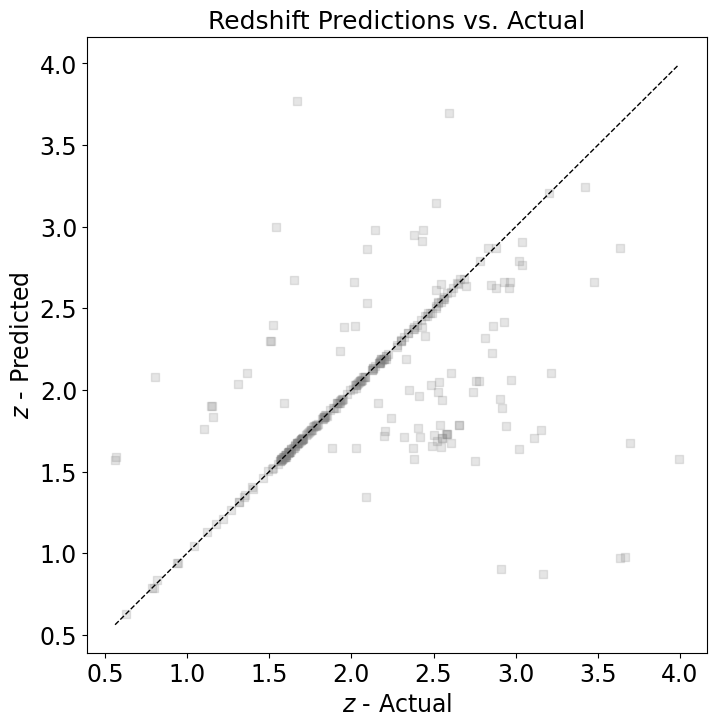

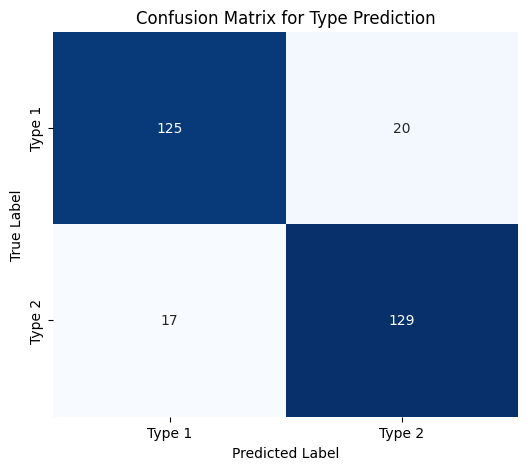

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def bin_index_to_redshift(bin_index, bin_categories):
    """ Convert a bin index back to a redshift value """
    bin_width = bin_categories[1] - bin_categories[0]
    return bin_categories[bin_index] + bin_width / 2

def inverse_transform(normalized_value, mean, std):
    return normalized_value * std + mean

def plot_predictions(actual, predicted, task_name, x_label, y_label):
    # Ensure inputs are numpy arrays and are 1-dimensional
    actual = np.asarray(actual).flatten()
    predicted = np.asarray(predicted).flatten()
    
    # Set up a subplot grid with 1 row
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Scatter plot
    ax.plot([min(actual), max(actual)], [min(actual), max(actual)], 'k--', lw=1)
    ax.scatter(actual, predicted, alpha=0.2, s=40, marker='s', color='grey')
    ax.set_xlabel(x_label, size=17)
    ax.set_ylabel(y_label, size=17)
    ax.xaxis.set_tick_params(labelsize=17)
    ax.yaxis.set_tick_params(labelsize=17)
    plt.title(f'{task_name} Predictions vs. Actual', size=18)
    plt.show()

def plot_confusion_matrix(actual, predicted, class_labels):
    # Compute confusion matrix
    cm = confusion_matrix(actual, predicted)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for Type Prediction')
    plt.show()

# Unpack predictions for each task
redshift_predictions, emission_mask_predictions, mstar_predictions, type_predictions = all_predictions

# Redshift predictions
redshift_bin_indices = np.argmax(redshift_predictions, axis=1)
predicted_redshifts = np.array([bin_index_to_redshift(idx, bin_categories) for idx in redshift_bin_indices])

# Inverse transform for Mstar predictions
mstar_predictions_rescaled = inverse_transform(mstar_predictions, mstar_mean, mstar_std)
Y_test_mstar_original = inverse_transform(Y_test_mstar, mstar_mean, mstar_std)


# input mask to select only a subset of spectra in the test 
mask = df_test['z']>0

# Plotting Redshift and Mstar
plot_predictions(Y_test[mask], predicted_redshifts[mask], 'Redshift',
                 x_label=r'$z$ - Actual', y_label=r'$z$ - Predicted')
# plot_predictions(Y_test_mstar_original[mask], mstar_predictions_rescaled[mask], 'Mstar',
#                  x_label=r'log(M$_{star} ~/~ [\rm M_{\odot}]$) - Actual', 
#                  y_label=r'log(M$_{star} ~/~ [\rm M_{\odot}]$) - Predicted')

# Confusion Matrix for Type Prediction
# Get predicted classes by taking the argmax of type predictions (for one-hot encoded predictions)
predicted_type_classes = np.argmax(type_predictions, axis=1)
actual_type_classes = np.argmax(Y_test_type_onehot, axis=1)

# Plot confusion matrix for type predictions
plot_confusion_matrix(actual_type_classes, predicted_type_classes, class_labels=['Type 1', 'Type 2'])


#### check residuals

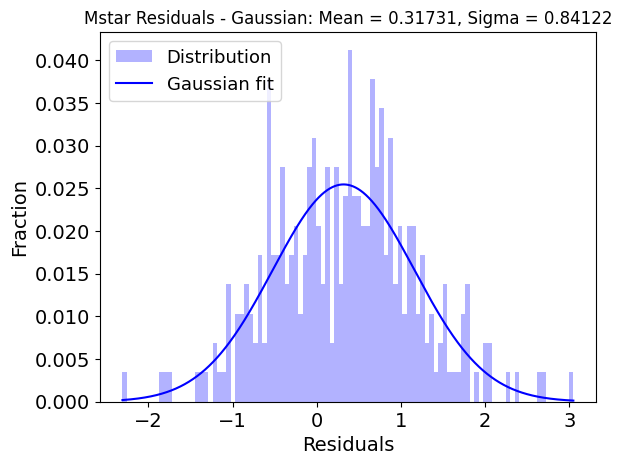

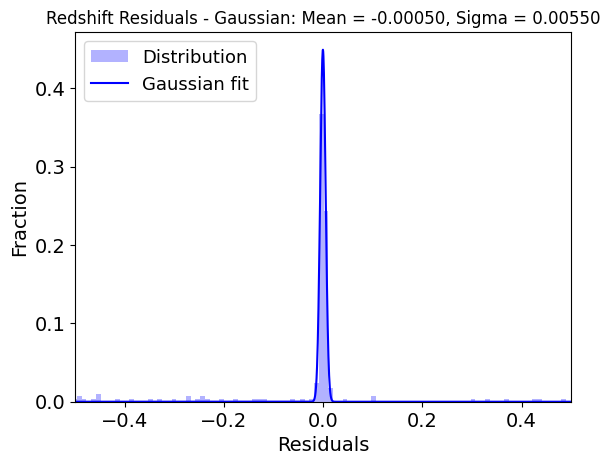

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gaussian(x, mean, amplitude, standard_deviation):
    """Gaussian function for curve fitting."""
    return amplitude * np.exp(- (x - mean)**2 / (2 * standard_deviation ** 2))

# -------------------------------
# Calculate residuals for Mstar
# -------------------------------
mstar_residuals = mstar_predictions_rescaled[mask].flatten() - Y_test_mstar_original[mask]

# Create histogram for Mstar residuals
mstar_bin_heights, mstar_bin_borders, _ = plt.hist(
    mstar_residuals, bins=100, label='Distribution', density=False, alpha=0.3, color='b',
    weights=[1.0 / len(mstar_residuals)] * len(mstar_residuals)
)
mstar_bin_centers = mstar_bin_borders[:-1] + np.diff(mstar_bin_borders) / 2

# Fit a Gaussian to the Mstar histogram data
mstar_popt, _ = curve_fit(gaussian, mstar_bin_centers, mstar_bin_heights, p0=[0., max(mstar_bin_heights), np.std(mstar_residuals)])

# Plot the fitted Gaussian for Mstar
mstar_x_interval_for_fit = np.linspace(mstar_bin_borders[0], mstar_bin_borders[-1], 10000)
plt.plot(mstar_x_interval_for_fit, gaussian(mstar_x_interval_for_fit, *mstar_popt), label='Gaussian fit', color='blue')
plt.title(f'Mstar Residuals - Gaussian: Mean = {mstar_popt[0]:.5f}, Sigma = {mstar_popt[2]:.5f}')
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Fraction', fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=13, loc='upper left')
plt.show()

# -------------------------------
# Calculate residuals for Redshift
# -------------------------------
redshift_residuals = predicted_redshifts[mask] - Y_test[mask]

# Create histogram for Redshift residuals
redshift_bin_heights, redshift_bin_borders, _ = plt.hist(
    redshift_residuals, bins=500, label='Distribution', density=False, alpha=0.3, color='blue',
    weights=[1.0 / len(redshift_residuals)] * len(redshift_residuals)
)
redshift_bin_centers = redshift_bin_borders[:-1] + np.diff(redshift_bin_borders) / 2

# Fit the Gaussian to the Redshift histogram data
redshift_popt, _ = curve_fit(gaussian, redshift_bin_centers, redshift_bin_heights, p0=[0., max(redshift_bin_heights), np.std(redshift_residuals)])

# Plot the fitted Gaussian for Redshift
redshift_x_interval_for_fit = np.linspace(redshift_bin_borders[0], redshift_bin_borders[-1], 10000)
plt.plot(redshift_x_interval_for_fit, gaussian(redshift_x_interval_for_fit, *redshift_popt), label='Gaussian fit', color='blue')
plt.title(f'Redshift Residuals - Gaussian: Mean = {redshift_popt[0]:.5f}, Sigma = {redshift_popt[2]:.5f}')
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Fraction', fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=13, loc='upper left')
plt.xlim(-0.5, 0.5)
plt.show()


(array([  4.,   2.,   3.,  20.,  27., 207.,  11.,  14.,   2.,   1.]),
 array([-2.68723627, -2.20894112, -1.73064597, -1.25235082, -0.77405567,
        -0.29576051,  0.18253464,  0.66082979,  1.13912494,  1.61742009,
         2.09571524]),
 <BarContainer object of 10 artists>)

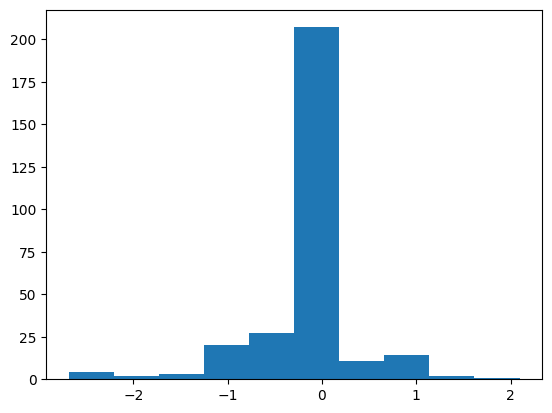

In [65]:
plt.hist(redshift_residuals)

#### residuals check

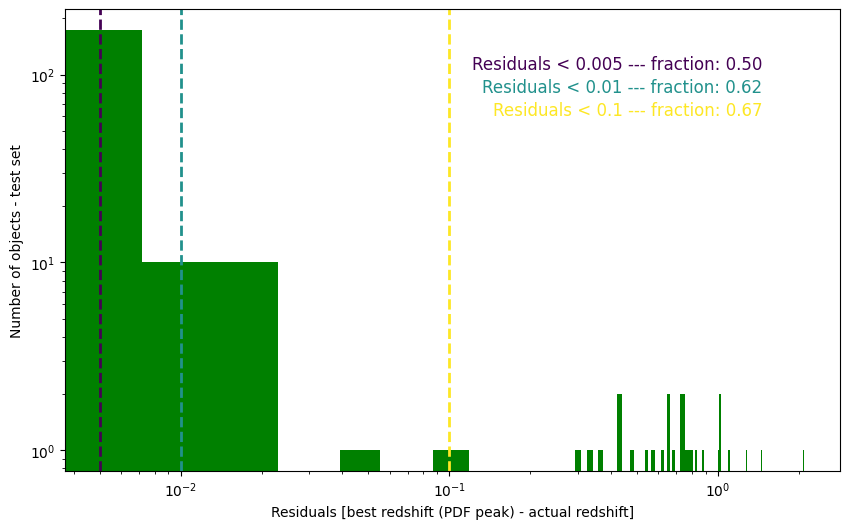

Residuals < 0.005 --- fraction: 0.50
Residuals < 0.01 --- fraction: 0.62
Residuals < 0.1 --- fraction: 0.67


In [66]:
def plot_residuals_with_thresholds(residuals, thresholds):
    # Create histogram of residuals
    plt.figure(figsize=(10, 6))
    bin_heights, bin_borders, _ = plt.hist(residuals, bins=300, alpha=1, color='g')
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

    total_objects = len(residuals)  # Total number of objects in the test set

    # For each threshold, draw a vertical line and annotate the fraction
    colors = plt.cm.viridis(np.linspace(0, 1, len(thresholds)))  # Generate distinct colors
    for threshold, color in zip(thresholds, colors):
        plt.axvline(x=threshold, color=color, linestyle='--', linewidth=2, label=f'Threshold = {threshold}')
        
        num_objects_below_threshold = np.sum(np.abs(residuals) < threshold)
        fraction_below_threshold = num_objects_below_threshold / total_objects
        
        # Place text on the right side of the plot
        plt.text(0.9, 0.9 - 0.05 * thresholds.index(threshold), 
                 f'Residuals < {threshold} --- fraction: {fraction_below_threshold:.2f}', 
                 verticalalignment='top', horizontalalignment='right', color=color, fontsize=12, transform=plt.gca().transAxes)

    plt.xlabel('Residuals [best redshift (PDF peak) - actual redshift]')
    plt.ylabel('Number of objects - test set')
    plt.semilogx()
    plt.semilogy()
    plt.show()

# visualise
thresholds = [0.005, 0.01, 0.1]  # User-defined thresholds
plot_residuals_with_thresholds(redshift_residuals, thresholds)




for threshold in thresholds:
    num_objects_below_threshold = np.sum(np.abs(redshift_residuals) < threshold)
    fraction_below_threshold = num_objects_below_threshold / len(redshift_residuals)
    print(f'Residuals < {threshold} --- fraction: {fraction_below_threshold:.2f}')

#### check individual spectra

1/1 [==============================] - 0s 60ms/step


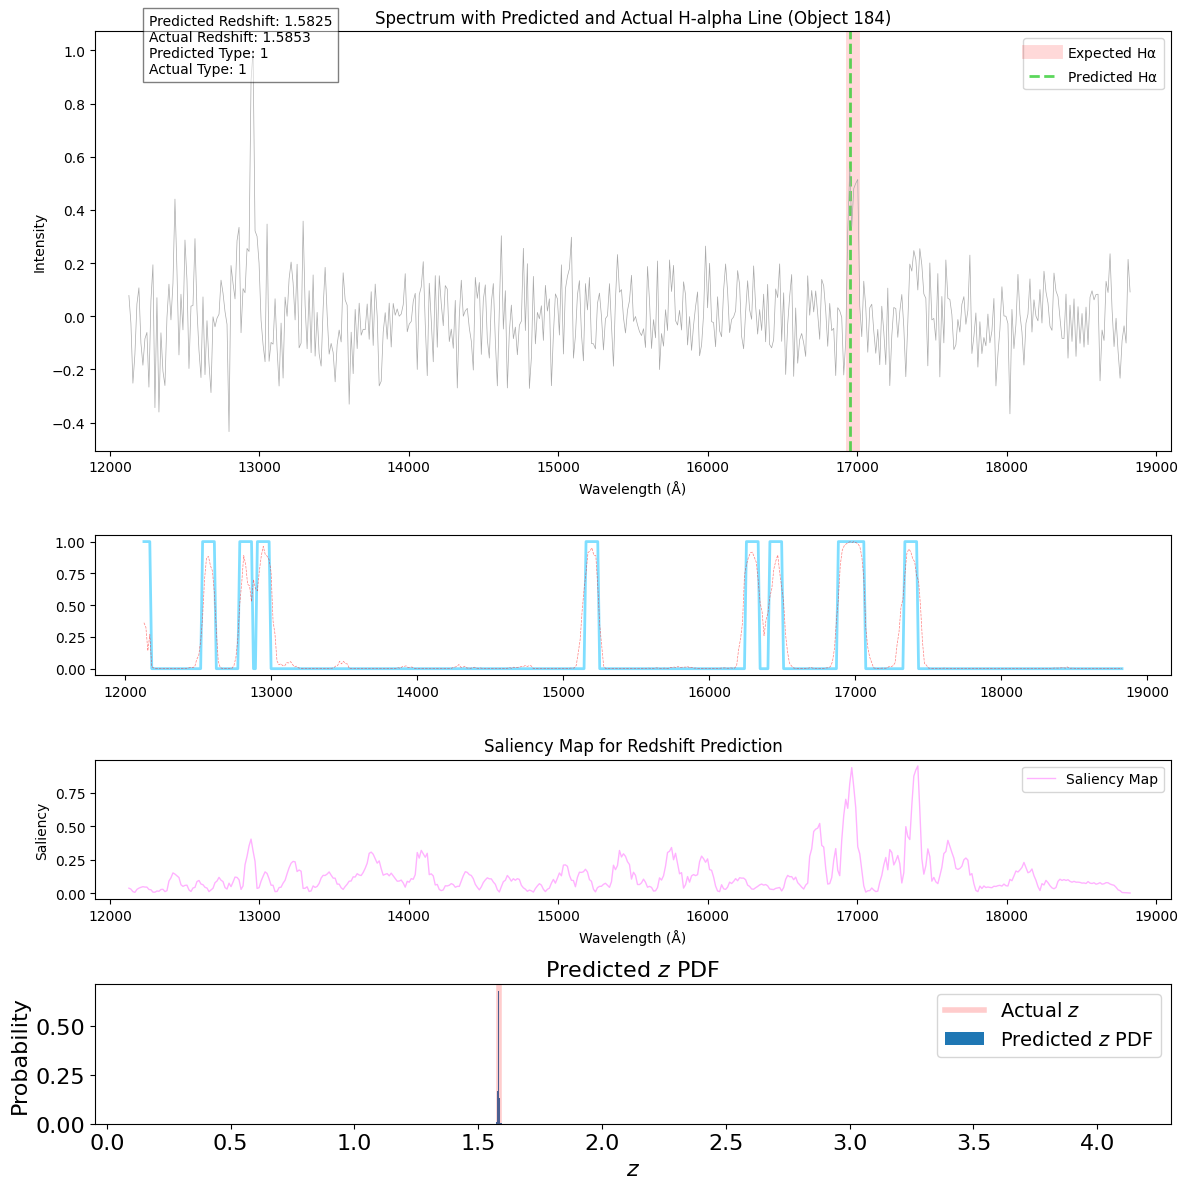

In [54]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, uniform_filter1d

def plot_spectrum_with_halpha(index, X_test, test_continuum, Y_test, Y_test_type, model, bin_categories, wavelength_axis):
    # Predict the redshift, emission lines, mstar, and type for the selected object
    object_spectrum = X_test[index]
    object_continuum = test_continuum[index]
        
    predictions = model.predict([np.expand_dims(object_spectrum, axis=0), np.expand_dims(object_continuum, axis=0)])

    # Extract the redshift prediction - find the bin with the highest probability
    predicted_redshift_bin = np.argmax(predictions[0][0])
    predicted_redshift = bin_categories[predicted_redshift_bin] + ((bin_categories[1] - bin_categories[0]) / 2)

    # Actual redshift
    actual_redshift = Y_test[index]

    # Extract the type prediction
    predicted_type = np.argmax(predictions[3][0])  # Assuming type is the fourth output
    actual_type = np.argmax(Y_test_type[index])

    # H-alpha line wavelength in Ångström (rest frame) in vacuum
    h_alpha_rest = 6564.6

    # Calculate the observed positions of the H-alpha line
    predicted_h_alpha_observed = h_alpha_rest * (1 + predicted_redshift)
    actual_h_alpha_observed = h_alpha_rest * (1 + actual_redshift)

    fig, (ax1, ax4, ax2, ax3) = plt.subplots(4, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [3, 1, 1, 1]})

    # Plot the spectrum
    ax1.plot(wavelength_axis, object_spectrum / object_spectrum.max(), c='darkgrey',lw=0.5, alpha=1)

    # Plot the predicted and actual H-alpha lines
    ax1.axvline(actual_h_alpha_observed, color='red', linestyle='-', label=r'Expected $\rm H\alpha$', zorder=-2, alpha=0.15, lw=10)
    ax1.axvline(predicted_h_alpha_observed, color='limegreen', linestyle='--', label=r'Predicted $\rm H\alpha$', lw=2, alpha=0.8, zorder=-1)

    # Plot predicted and actual emission lines
    ax4.plot(wavelength_axis, emission_line_masks_test[index]/emission_line_masks_test[index].max(), '-', label='Expected spectral lines', lw=2, alpha=0.5, color='deepskyblue', zorder=-5)
    ax4.plot(wavelength_axis, predictions[1][0]/predictions[1][0].max(), '--', label='Predicted spectral lines',  lw=0.5, alpha=0.5, color='red', zorder=-4)

    ax1.set_ylabel('Intensity')
    ax1.set_xlabel('Wavelength (Å)')
    ax1.legend(loc='upper right')
    ax1.set_xlim(11900, 19100)
    ax1.set_title(f'Spectrum with Predicted and Actual H-alpha Line (Object {index})')

    # Add an inset with redshift and type information
    textstr = (f'Predicted Redshift: {predicted_redshift:.4f}\nActual Redshift: {actual_redshift:.4f}\n'
               f'Predicted Type: {predicted_type}\nActual Type: {actual_type}')
    ax1.text(0.05, 0.9, textstr, transform=ax1.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

    # Second subplot for redshift probability distribution
    bar_width = bin_categories[1] - bin_categories[0]
    adjusted_bin_categories = bin_categories + bar_width / 2
    ax3.axvline(x=actual_redshift, color='r', linestyle='-', lw=4, alpha =0.2, label=r'Actual $z$')
    ax3.bar(adjusted_bin_categories, gaussian_filter1d(predictions[0][0], 0.5), width=bar_width, label=r'Predicted $z$ PDF', alpha=1)
    ax3.set_xlabel('$z$', fontsize=16)
    ax3.set_ylabel('Probability', fontsize=16)
    ax3.xaxis.set_tick_params(labelsize=16)
    ax3.yaxis.set_tick_params(labelsize=16)
    ax3.legend(fontsize=14)
    ax3.set_title(r'Predicted $z$ PDF', fontsize=16)


    # Saliency Map for Redshift Prediction
    input_spectrum_tensor = tf.convert_to_tensor(np.expand_dims(object_spectrum, axis=0), dtype=tf.float32)
    input_continuum_tensor = tf.convert_to_tensor(np.expand_dims(object_continuum, axis=0), dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(input_spectrum_tensor)
        prediction = model([input_spectrum_tensor, input_continuum_tensor])[0]
    
    gradient = tape.gradient(prediction, input_spectrum_tensor)[0]
    processed_grad = tf.abs(gradient)
    epsilon = 1e-12  # Small value to avoid division by zero
    processed_grad /= (tf.math.reduce_max(processed_grad) + epsilon)
    processed_grad = processed_grad.numpy().flatten()  # Flatten to ensure it matches the wavelength_axis dimension

    # print(processed_grad)

    # Plot the saliency map
    if processed_grad.shape[0] != wavelength_axis.shape[0]:
        raise ValueError("Saliency map and wavelength axis have different dimensions")

    ax2.plot(wavelength_axis, gaussian_filter1d(processed_grad, 0.5), label='Saliency Map', color='magenta', alpha=0.3, lw=1)
    ax2.set_xlabel('Wavelength (Å)')
    ax2.set_ylabel('Saliency')
    ax2.set_title('Saliency Map for Redshift Prediction')
    ax2.set_xlim(11900, 19100)
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Example usage
# index = 99
index = np.random.choice(range(len(X_test)))
plot_spectrum_with_halpha(index, X_test, test_continuum, Y_test, Y_test_type_onehot, model, bin_categories, wavelength_axis)
